In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


In [3]:
import rasterio
import numpy as np
import glob
import os

# Directory where rasters are stored
raster_dir = "F:\\Biomass tiffs\\Output\\Clippy"
raster_files = sorted(glob.glob(os.path.join(raster_dir, "*.tif")))

# Optionally extract years from filenames
# years = [int(os.path.basename(f)[4:8]) for f in raster_files] #For non-clipped output
years = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in raster_files]

# Read all rasters into a 3D array (time, rows, cols)
stack = []
for file in raster_files:
    with rasterio.open(file) as src:
        stack.append(src.read(1))  # Read first band

stack = np.stack(stack)  # Shape: (years, rows, cols)

In [6]:
import sklearn
from sklearn.linear_model import LinearRegression

# Prepare x values (years) for regression
X = np.array(years).reshape(-1, 1)  # shape: (n_years, 1)
rows, cols = stack.shape[1:]

# Initialize output array for slopes
slope_array = np.full((rows, cols), np.nan)

# Loop over each pixel
for i in range(rows):
    for j in range(cols):
        y = stack[:, i, j]
        if np.all(np.isfinite(y)):
            model = LinearRegression().fit(X, y)
            slope_array[i, j] = model.coef_[0]  # slope


In [7]:
out_path = "F:\\Biomass tiffs\\All_trend\\trend_2010to2023.tif"

# Use metadata from one of the input files
with rasterio.open(raster_files[0]) as src:
    meta = src.meta.copy()

meta.update(dtype=rasterio.float32, count=1)

with rasterio.open(out_path, 'w', **meta) as dst:
    dst.write(slope_array.astype(rasterio.float32), 1)

print(f"Saved slope image to {out_path}")

Saved slope image to F:\Biomass tiffs\All_trend\trend_2010to2023.tif


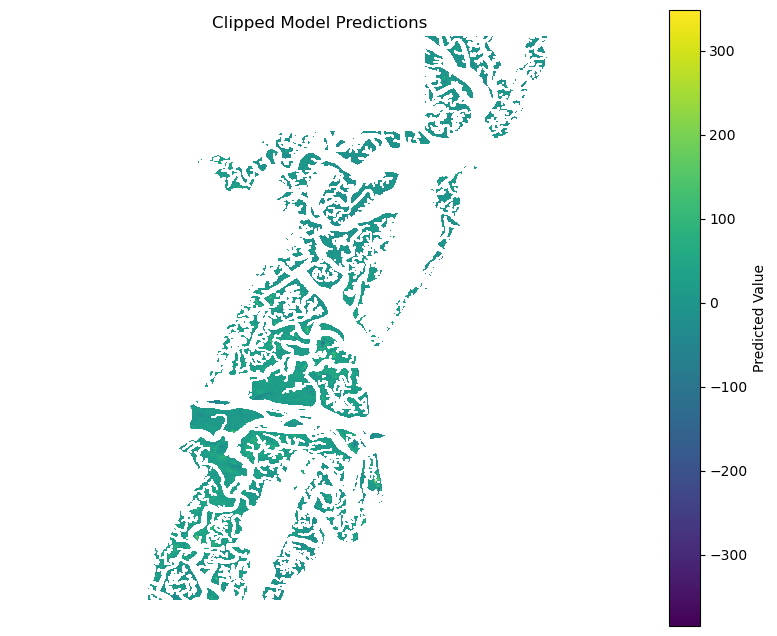

In [9]:
##Clipping to GA_estuaries file
# import geopandas as gpd
# import rasterio
# from rasterio.mask import mask
# import matplotlib.pyplot as plt

# # Paths
# raster_path = out_path
# shapefile_path = "F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_estuaries.shp"

# # Load the shapefile
# gdf = gpd.read_file(shapefile_path)
# gdf = gdf.to_crs("EPSG:4326")  # Optional: match CRS if needed

# # Open the raster and clip it
# with rasterio.open(raster_path) as src:
#     # Ensure CRS matches
#     if src.crs != gdf.crs:
#         gdf = gdf.to_crs(src.crs)

#     # Convert GeoDataFrame geometry to GeoJSON-like mapping
#     shapes = gdf.geometry.values
#     out_image, out_transform = mask(src, shapes, crop=True)
#     out_meta = src.meta.copy()

# # Update metadata to match clipped output
# out_meta.update({
#     "height": out_image.shape[1],
#     "width": out_image.shape[2],
#     "transform": out_transform
# })

# # Plot the clipped prediction
# plt.figure(figsize=(10, 8))
# plt.imshow(out_image[0], cmap='viridis')
# plt.colorbar(label='Predicted Value')
# plt.title("Clipped Model Predictions")
# plt.axis('off')
# plt.show()

In [10]:
##Export clipped image
# clipped_path = f"F:/Biomass tiffs/All_trend/clipped_2017to2023.tif"
# with rasterio.open(clipped_path, "w", **out_meta) as dest:
#     dest.write(out_image)

In [ ]:
#Finito